In [2]:
import plotly.express as px
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import nodevectors
import networkx as nx
from sklearn.decomposition import PCA

### Useful functions

In [3]:
def symmetrises(A, diag=False):
    if diag:
        return np.tril(A,0) + np.transpose(np.tril(A,-1))
    else:
        return np.tril(A,-1) + np.transpose(np.tril(A,-1))

In [4]:
def gaussian_ellipse(mean, cov):
    if mean.shape == (1,2):
        mean = np.array(mean)[0]
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    rtheta = np.arctan2(u[1], u[0])
    v = 3. * np.sqrt(2.) * np.sqrt(v)
    width = v[0]; height = v[1]
    
    R = np.array([
        [np.cos(rtheta), -np.sin(rtheta)],
        [np.sin(rtheta),  np.cos(rtheta)],
        ])    
    theta = np.deg2rad(np.arange(0.0, 360.0, 1.0))
    x = 0.5 * width * np.cos(theta)
    y = 0.5 * height * np.sin(theta)    
    x, y = np.dot(R,np.array([x, y]))
    x += mean[0]
    y += mean[1]
    
    return [x,y]

In [5]:
def right_embed(As, K):
    # Construct rectangular matrices
    if len(As.shape) == 2:
        As = np.array([As[:,:]])
    
    if len(As.shape) == 3:
        T = len(As)
        A = As[0,:,:]
        for t in range(1,T):
            A = np.block([A,As[t]])
    
    # Spectral embedding
    UA, SA, VAt = np.linalg.svd(A); VA = VAt.T
          
    YA = np.zeros((T,n,K))
    for t in range(T):
        YA[t] = VA[t*n:(t+1)*n,0:K].dot(np.diag(np.sqrt(SA[0:K])))     
    
    return YA

In [6]:
def embed(A, K):
    UA, SA, VAt = np.linalg.svd(A)
    XA = UA[:,0:K].dot(np.diag(np.sqrt(SA[0:K])))    
    return XA

In [7]:
def omni_embed(As, K):
    # Construct omnibus matrices    
    T = len(As)
    A = np.zeros((T*n,T*n))
    
    for t1 in range(T):
        for t2 in range(T):
            if t1 == t2:
                A[t1*n:(t1+1)*n,t1*n:(t1+1)*n] = As[t1]
            else:
                A[t1*n:(t1+1)*n,t2*n:(t2+1)*n] = (As[t1] + As[t2])/2
    
    XA = embed(A, K*T)
    XAs = np.zeros((T,n,K*T))
    for t in range(T):
        XAs[t] = XA[t*n:(t+1)*n]
            
    return XAs

In [8]:
def n2v_embed(As, K, n, p=1, q=1):
    """Computes the node2vec embedding for multiple adjacency snapshots"""

    # Construct the unfolded adjacency
    if len(As.shape) == 2:
        As = np.array([As[:, :]])

    if len(As.shape) == 3:
        T = len(As)
        A = As[0, :, :]
        for t in range(1, T):
            A = np.block([A, As[t]])

    # Construct the dilated unfolded adjacency matrix
    DA = np.zeros((n + n * T, n + n * T))
    DA[0:n, n:] = A
    DA[n:, 0:n] = A.T

    # Compute node2vec
    G = nx.from_numpy_matrix(DA)
    n2v_obj = nodevectors.Node2Vec(
        n_components=K,
        return_weight=1/p,
        neighbor_weight=1/q
    )
    n2v = n2v_obj.fit_transform(G)

    right_n2v = n2v[n:, :]

    YA = np.zeros((T, n, K))
    for t in range(T):
        YA[t] = right_n2v[t * n:(t + 1) * n, 0:K]

    return YA


### Temporal SBM

A minimal example demonstrating both consistency over time and consistency within time.

In [9]:
np.random.seed(0)

In [10]:
K = 4      # Number of communities
T = 2      # Number of time steps
n = 1000   # Number of nodes

In [11]:
pi = np.repeat(1/K, K)
Z = np.repeat(range(K), n/K)

colours = np.array(list(mpl.colors.TABLEAU_COLORS.keys())[0:K])
Zcol = colours[Z]

In [12]:
B1 = np.array([[0.08, 0.02, 0.18, 0.10],
               [0.02, 0.20, 0.04, 0.10],
               [0.18, 0.04, 0.02, 0.02],
               [0.10, 0.10, 0.02, 0.06]])
B2 = np.array([[0.16, 0.16, 0.04, 0.10],
               [0.16, 0.16, 0.04, 0.10],
               [0.04, 0.04, 0.09, 0.02],
               [0.10, 0.10, 0.02, 0.06]])

In [13]:
Bs = np.zeros((T,K,K))
Bs[0] = B1
Bs[1] = B2

In [14]:
As = np.zeros((T,n,n))
for t in range(T):
    As[t] = symmetrises(stats.bernoulli.rvs(Bs[t][Z,:][:,Z]))

In [15]:
YA_UASE = right_embed(As, K)

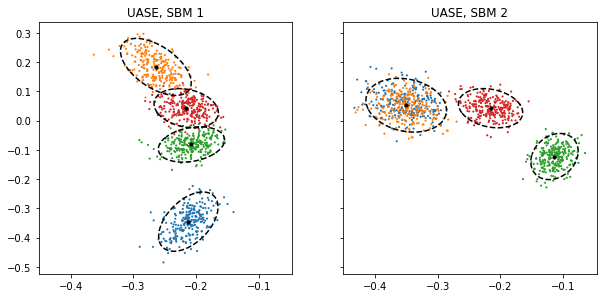

In [16]:
fig, axs = plt.subplots(1, T, figsize=(10.0,9.25/T), sharex=True, sharey=True)

for t in range(T):
    axs[t].scatter(YA_UASE[t,:,0], YA_UASE[t,:,1], marker='.', s=5, c=Zcol)
    axs[t].set_title('UASE, SBM ' + str(t+1))
    
# Blue/orange cluster at time 2
mean = np.mean(YA_UASE[1, (Z == 0)|(Z == 1)], axis=0)
cov = np.cov(YA_UASE[1, (Z == 0)|(Z == 1)].T)
axs[1].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[1].plot(ellipse[0], ellipse[1],'--', color='black')

# Red cluster at times 1 & 2
mean = np.mean(np.block([[YA_UASE[0, (Z == 3)]],[YA_UASE[1, (Z == 3)]]]), axis=0)
cov = np.cov(np.block([[YA_UASE[0, (Z == 3)]],[YA_UASE[1, (Z == 3)]]]).T)
axs[0].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[0].plot(ellipse[0], ellipse[1],'--', color='black')
axs[1].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[1].plot(ellipse[0], ellipse[1],'--', color='black')

# All other clusters
for (t, k) in [(0,0), (0,1), (0,2), (1,2)]:
    mean = np.mean(YA_UASE[t, (Z == k)], axis=0)
    cov = np.cov(YA_UASE[t, (Z == k)].T)
    axs[t].scatter(mean[0], mean[1], marker='o', s=10, c='black')
    ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
    axs[t].plot(ellipse[0], ellipse[1],'--', color='black');

#### Omnibus embedding

In [17]:
YA_omni = omni_embed(As, K)

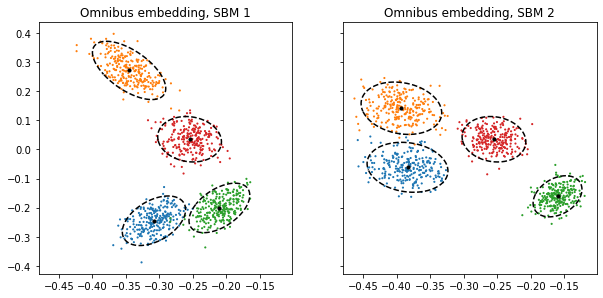

In [18]:
fig, axs = plt.subplots(1, T, figsize=(10.0,9.25/T), sharex=True, sharey=True)

for t in range(T):
    axs[t].scatter(YA_omni[t,:,0], YA_omni[t,:,1], marker='.', s=5, c=Zcol)
    axs[t].set_title('Omnibus embedding, SBM ' + str(t+1))

# Red cluster at times 1 & 2
mean = np.mean(np.block([[YA_omni[0, (Z == 3)]],[YA_omni[1, (Z == 3)]]]), axis=0)
cov = np.cov(np.block([[YA_omni[0, (Z == 3)]],[YA_omni[1, (Z == 3)]]]).T)
axs[0].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[0].plot(ellipse[0], ellipse[1],'--', color='black')
axs[1].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[1].plot(ellipse[0], ellipse[1],'--', color='black')

# All other clusters
for (t, k) in [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]:
    mean = np.mean(YA_omni[t, (Z == k)], axis=0)
    cov = np.cov(YA_omni[t, (Z == k)].T)
    axs[t].scatter(mean[0], mean[1], marker='o', s=10, c='black')
    ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
    axs[t].plot(ellipse[0], ellipse[1],'--', color='black');

#### Separate spectral embedding

In [19]:
YA_SSE = np.zeros((T,n,K))

for t in range(T):
    YA_SSE[t] = embed(As[t], K)

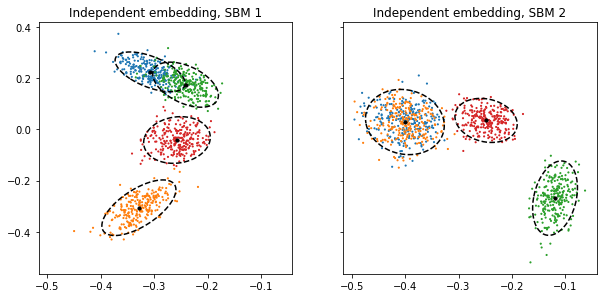

In [20]:
fig, axs = plt.subplots(1, T, figsize=(10.0,9.25/T), sharex=True, sharey=True)

for t in range(T):
    axs[t].scatter(YA_SSE[t,:,0], YA_SSE[t,:,1], marker='.', s=5, c=Zcol)
    axs[t].set_title('Independent embedding, SBM ' + str(t+1))
    
# Blue/orange cluster at time 2
mean = np.mean(YA_SSE[1, (Z == 0)|(Z == 1)], axis=0)
cov = np.cov(YA_SSE[1, (Z == 0)|(Z == 1)].T)
axs[1].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[1].plot(ellipse[0], ellipse[1],'--', color='black')

# All other clusters
for (t, k) in [(0,0), (0,1), (0,2), (0,3), (1,2), (1,3)]:
    mean = np.mean(YA_SSE[t, (Z == k)], axis=0)
    cov = np.cov(YA_SSE[t, (Z == k)].T)
    axs[t].scatter(mean[0], mean[1], marker='o', s=10, c='black')
    ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
    axs[t].plot(ellipse[0], ellipse[1],'--', color='black');

#### node2vec Embedding


In [21]:
# p = return parameter: high = less 2-hop redundancy, low = returns more
# q = in-out parameter: high = more local, low = more discovery
p = 1
q = 1
YA_n2v = n2v_embed(As=As, K=K, n=n, p=p, q=q)

Making walks... Done, T=4.39
Mapping Walk Names... Done, T=1.80
Training W2V... Done, T=38.52


In [22]:
YA_n2v_full = YA_n2v[0]

for t in range(1,T):
    YA_n2v_full = np.block([[YA_n2v_full], [YA_n2v[t]]])

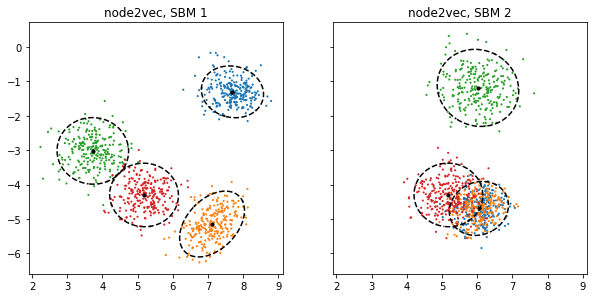

In [23]:
fig, axs = plt.subplots(1, T, figsize=(10.0,9.25/T), sharex=True, sharey=True)

for t in range(T):
    axs[t].scatter(YA_n2v[t,:,0], YA_n2v[t,:,1], marker='.', s=5, c=Zcol)
    axs[t].set_title('node2vec, SBM ' + str(t+1))
    
# Blue/orange cluster at time 2
mean = np.mean(YA_n2v[1, (Z == 0)|(Z == 1)], axis=0)
cov = np.cov(YA_n2v[1, (Z == 0)|(Z == 1)].T)
axs[1].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[1].plot(ellipse[0], ellipse[1],'--', color='black')

# Red cluster at times 1 & 2
mean = np.mean(np.block([[YA_n2v[0, (Z == 3)]],[YA_n2v[1, (Z == 3)]]]), axis=0)
cov = np.cov(np.block([[YA_n2v[0, (Z == 3)]],[YA_n2v[1, (Z == 3)]]]).T)
axs[0].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[0].plot(ellipse[0], ellipse[1],'--', color='black')
axs[1].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[1].plot(ellipse[0], ellipse[1],'--', color='black')

# All other clusters
for (t, k) in [(0,0), (0,1), (0,2), (1,2)]:
    mean = np.mean(YA_n2v[t, (Z == k)], axis=0)
    cov = np.cov(YA_n2v[t, (Z == k)].T)
    axs[t].scatter(mean[0], mean[1], marker='o', s=10, c='black')
    ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
    axs[t].plot(ellipse[0], ellipse[1],'--', color='black');

### Joint plot for paper

In [24]:
fig = plt.figure()
handles = [plt.scatter([],[], color='tab:blue', marker='o', s=12, label='Community 1'),
           plt.scatter([],[], color='tab:orange', marker='o', s=12, label='Community 2'),
           plt.scatter([],[], color='tab:green', marker='o', s=12, label='Community 3'),
           plt.scatter([],[], color='tab:red', marker='o', s=12, label='Community 4')]
plt.close()

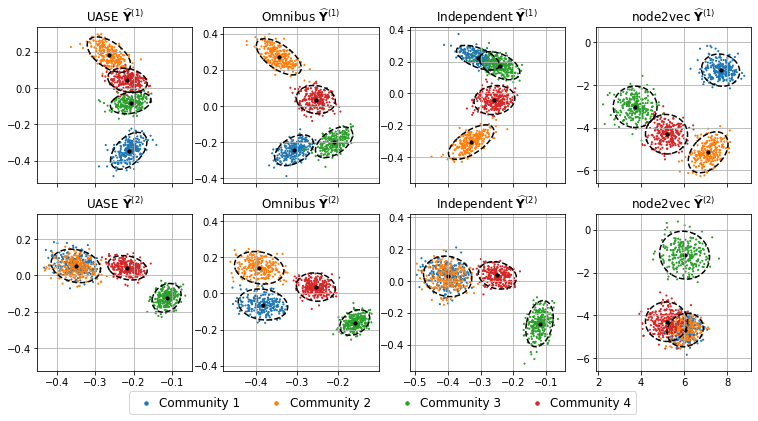

In [27]:
fig, axs = plt.subplots(2, 4, figsize=(12.8,6.2), sharex='col', sharey='col')

for t in range(T):
    axs[t,0].grid(); axs[t,1].grid(); axs[t,2].grid(); axs[t,3].grid()
    axs[t,0].scatter(YA_UASE[t,:,0], YA_UASE[t,:,1], marker='.', s=5, c=Zcol)
    axs[t,1].scatter(YA_omni[t,:,0], YA_omni[t,:,1], marker='.', s=5, c=Zcol)
    axs[t,2].scatter(YA_SSE[t,:,0], YA_SSE[t,:,1], marker='.', s=5, c=Zcol)
    axs[t,3].scatter(YA_n2v[t,:,0], YA_n2v[t,:,1], marker='.', s=5, c=Zcol)
    axs[t,0].tick_params(axis='y', pad=2)
    axs[t,1].tick_params(axis='y', pad=2)
    axs[t,2].tick_params(axis='y', pad=2)
    axs[t,3].tick_params(axis='y', pad=2)

### UASE clusters ###

# Blue/orange cluster at time 2
mean = np.mean(YA_UASE[1, (Z == 0)|(Z == 1)], axis=0)
cov = np.cov(YA_UASE[1, (Z == 0)|(Z == 1)].T)
axs[1,0].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[1,0].plot(ellipse[0], ellipse[1],'--', color='black')

# Red cluster at times 1 & 2
mean = np.mean(np.block([[YA_UASE[0, (Z == 3)]],[YA_UASE[1, (Z == 3)]]]), axis=0)
cov = np.cov(np.block([[YA_UASE[0, (Z == 3)]],[YA_UASE[1, (Z == 3)]]]).T)
axs[0,0].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[0,0].plot(ellipse[0], ellipse[1],'--', color='black')
axs[1,0].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[1,0].plot(ellipse[0], ellipse[1],'--', color='black')

# All other clusters
for (t, k) in [(0,0), (0,1), (0,2), (1,2)]:
    mean = np.mean(YA_UASE[t, (Z == k)], axis=0)
    cov = np.cov(YA_UASE[t, (Z == k)].T)
    axs[t,0].scatter(mean[0], mean[1], marker='o', s=10, c='black')
    ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
    axs[t,0].plot(ellipse[0], ellipse[1],'--', color='black')

### Omnibus clusters ###    

# Red cluster at times 1 & 2
mean = np.mean(np.block([[YA_omni[0, (Z == 3)]],[YA_omni[1, (Z == 3)]]]), axis=0)
cov = np.cov(np.block([[YA_omni[0, (Z == 3)]],[YA_omni[1, (Z == 3)]]]).T)
axs[0,1].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[0,1].plot(ellipse[0], ellipse[1],'--', color='black')
axs[1,1].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[1,1].plot(ellipse[0], ellipse[1],'--', color='black')

# All other clusters
for (t, k) in [(0,0), (0,1), (0,2), (1,0), (1,1), (1,2)]:
    mean = np.mean(YA_omni[t, (Z == k)], axis=0)
    cov = np.cov(YA_omni[t, (Z == k)].T)
    axs[t,1].scatter(mean[0], mean[1], marker='o', s=10, c='black')
    ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
    axs[t,1].plot(ellipse[0], ellipse[1],'--', color='black')

### Separate clusters ###

# Blue/orange cluster at time 2
mean = np.mean(YA_SSE[1, (Z == 0)|(Z == 1)], axis=0)
cov = np.cov(YA_SSE[1, (Z == 0)|(Z == 1)].T)
axs[1,2].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[1,2].plot(ellipse[0], ellipse[1],'--', color='black')

# All other clusters
for (t, k) in [(0,0), (0,1), (0,2), (0,3), (1,2), (1,3)]:
    mean = np.mean(YA_SSE[t, (Z == k)], axis=0)
    cov = np.cov(YA_SSE[t, (Z == k)].T)
    axs[t,2].scatter(mean[0], mean[1], marker='o', s=10, c='black')
    ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
    axs[t,2].plot(ellipse[0], ellipse[1],'--', color='black')

### node2vec clusters ###

# Blue/orange cluster at time 2
mean = np.mean(YA_n2v[1, (Z == 0)|(Z == 1)], axis=0)
cov = np.cov(YA_n2v[1, (Z == 0)|(Z == 1)].T)
axs[1,3].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[1,3].plot(ellipse[0], ellipse[1],'--', color='black')

# Red cluster at times 1 & 2
mean = np.mean(np.block([[YA_n2v[0, (Z == 3)]],[YA_n2v[1, (Z == 3)]]]), axis=0)
cov = np.cov(np.block([[YA_n2v[0, (Z == 3)]],[YA_n2v[1, (Z == 3)]]]).T)
axs[0,3].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[0,3].plot(ellipse[0], ellipse[1],'--', color='black')
axs[1,3].scatter(mean[0], mean[1], marker='o', s=10, c='black')
ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
axs[1,3].plot(ellipse[0], ellipse[1],'--', color='black')

# All other clusters
for (t, k) in [(0,0), (0,1), (0,2), (1,2)]:
    mean = np.mean(YA_n2v[t, (Z == k)], axis=0)
    cov = np.cov(YA_n2v[t, (Z == k)].T)
    axs[t,3].scatter(mean[0], mean[1], marker='o', s=10, c='black')
    ellipse = gaussian_ellipse(mean[0:2], cov[0:2,0:2])
    axs[t,3].plot(ellipse[0], ellipse[1],'--', color='black')
    
axs[0,0].set_title(r'UASE $\widehat{\bf{Y}}^{(1)}$')
axs[1,0].set_title(r'UASE $\widehat{\bf{Y}}^{(2)}$')
axs[0,1].set_title(r'Omnibus $\widehat{\bf{Y}}^{(1)}$')
axs[1,1].set_title(r'Omnibus $\widehat{\bf{Y}}^{(2)}$')
axs[0,2].set_title(r'Independent $\widehat{\bf{Y}}^{(1)}$')
axs[1,2].set_title(r'Independent $\widehat{\bf{Y}}^{(2)}$')
axs[0,3].set_title(r'node2vec $\widehat{\bf{Y}}^{(1)}$')
axs[1,3].set_title(r'node2vec $\widehat{\bf{Y}}^{(2)}$')

fig.legend(handles=handles, bbox_to_anchor=(0.5,0), loc='lower center', ncol=4, fancybox=True, fontsize=12, handletextpad=0.1)
plt.subplots_adjust(bottom = 0.11);